In [3]:
import torch, torchvision, torchinfo, pandas as pd, numpy as np, matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image

In [4]:
image_with_label = pd.read_csv("../data/train.csv")
image_with_label

Unnamed: 0                                        file_name  label
0               0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1               1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2               2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3               3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4               4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
...           ...                                              ...    ...
79945       79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0
79946       79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1
79947       79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0
79948       79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1
79949       79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0

[79950 rows x 3 columns]

In [5]:
image_with_label.drop(columns=["Unnamed: 0"], inplace=True)
image_with_label

file_name  label
0      train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1      train_data/041be3153810433ab146bc97d5af505c.jpg      0
2      train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3      train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4      train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
...                                                ...    ...
79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0
79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1
79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0
79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1
79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0

[79950 rows x 2 columns]

In [84]:
DEFAULT_TRANSFORMER = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomDataset(Dataset):
    def __init__(self, image_with_label, images_dir="../data/", transformer=DEFAULT_TRANSFORMER):
        super(CustomDataset, self).__init__()
        self.image_with_label = image_with_label
        self.images_dir = images_dir
        self.transformer = transformer

    def __len__(self):
        return self.image_with_label.shape[0]

    def load_image(self, path):
        image = Image.open(self.images_dir + path)
        if self.transformer is None:
            return image
        return self.transformer(image)

    def __getitem__(self, index):
        file_path, label = self.image_with_label.iloc[index]
        image = self.load_image(file_path)
        if image.shape[0] < 3:
            return self.__getitem__(index+1)
        return image, label

In [85]:
whole_dataset = CustomDataset(image_with_label)
len(whole_dataset)

79950

torch.Size([3, 64, 64]) 1


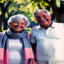

In [86]:
x, y = whole_dataset[0]
print(x.shape, y)

transforms.ToPILImage()(x)

In [87]:
TOTAL_LENGTH = len(whole_dataset)
VAL_LENGTH = int(TOTAL_LENGTH * 0.1)
TRAIN_LENGTH = int(TOTAL_LENGTH - VAL_LENGTH)

TOTAL_LENGTH, TRAIN_LENGTH, VAL_LENGTH

(79950, 71955, 7995)

In [88]:
train_dataset, val_dataset = torch.utils.data.random_split(whole_dataset, lengths=[TRAIN_LENGTH, VAL_LENGTH])

len(train_dataset), len(val_dataset)

(71955, 7995)

In [89]:
BATCH_SIZE = 32

def filter_condition(inputs):
    x, y = inputs
    # print(x.shape[0])
    return x.shape[0] == 3
    
def my_collate_fn(batch):
    batch = list(filter(filter_condition, batch))
    return torch.utils.data.dataloader.default_collate(batch)  

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=my_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=my_collate_fn)

train_dataloader

In [90]:
x, y = next(iter(train_dataloader))
x.shape, y

(torch.Size([32, 3, 64, 64]),
 tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 1, 0, 1, 1, 0, 1]))

In [91]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(TinyVGG, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.feed_forward = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 13 ** 2, output_shape)
        )
    def forward(self, inputs):
        return self.feed_forward(self.conv_layer2(self.conv_layer1(inputs)))

In [92]:
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(DEVICE)

model = TinyVGG(3, 10, 2).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

cpu


In [111]:
y_preds = model(x)
initial_loss = loss_fn(y_preds, y)
initial_loss

tensor(0.7235, grad_fn=<NllLossBackward0>)

In [112]:
torchinfo.summary(model=model,
        input_size=(32, 3, 64, 64), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGG (TinyVGG)                        [32, 3, 64, 64]      [32, 2]              --                   True
├─Sequential (conv_layer1)               [32, 3, 64, 64]      [32, 10, 30, 30]     --                   True
│    └─Conv2d (0)                        [32, 3, 64, 64]      [32, 10, 62, 62]     280                  True
│    └─ReLU (1)                          [32, 10, 62, 62]     [32, 10, 62, 62]     --                   --
│    └─Conv2d (2)                        [32, 10, 62, 62]     [32, 10, 60, 60]     910                  True
│    └─ReLU (3)                          [32, 10, 60, 60]     [32, 10, 60, 60]     --                   --
│    └─MaxPool2d (4)                     [32, 10, 60, 60]     [32, 10, 30, 30]     --                   --
├─Sequential (conv_layer2)               [32, 10, 30, 30]     [32, 10, 13, 13]     --                   True
│    └─Conv2d (0)   

In [113]:
EPOCHS = 2

history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

train_start = timer()

for epoch in tqdm(range(EPOCHS)):
    epoch_start = timer()
    
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    model.train()
    
    for batch, (train_x, train_y) in enumerate(train_dataloader):
        train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)
        
        train_preds = model(train_x)

        loss = loss_fn(train_preds, train_y)

        train_loss += loss
        train_acc += (torch.argmax(torch.softmax(train_preds, dim=1), dim=1) == train_y).sum().item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 700 == 0:
            print(f"Epoch: {epoch} | Batch: {batch} | Train Loss: {train_loss / (batch + 1)} | Train Accuracy: {train_acc / ((batch + 1) * BATCH_SIZE)}")
    
    train_acc /= len(train_dataset)
    train_loss /= len(train_dataset)
    
    history["epoch"].append(epoch)
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)

    model.eval()
    with torch.inference_mode():
        for val_x, val_y in val_dataloader:
            val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)
            
            val_preds = model(val_x)

            val_loss += loss_fn(val_preds, val_y)
            val_acc += (torch.argmax(torch.softmax(val_preds, dim=1), dim=1) == val_y).sum().item()
            
        val_acc /= len(val_dataset)
        val_loss /= len(val_dataset)

        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        epoch_end = timer()

        print(f"{epoch_end - epoch_start:.1f}/s Train Accuracy: {train_acc} | Train Loss: {train_loss} | Val Loss: {val_loss} | Val Accuracy: {val_acc}")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0 | Batch: 0 | Train Loss: 0.619911253452301 | Train Accuracy: 0.65625
Epoch: 0 | Batch: 700 | Train Loss: 0.5491734147071838 | Train Accuracy: 0.7323466476462197
Epoch: 0 | Batch: 1400 | Train Loss: 0.5448606014251709 | Train Accuracy: 0.7342969307637401
Epoch: 0 | Batch: 2100 | Train Loss: 0.5400839447975159 | Train Accuracy: 0.735051761066159
440.6/s Train Accuracy: 0.7348898617191301 | Train Loss: 0.016887815669178963 | Val Loss: 0.01600337028503418 | Val Accuracy: 0.7524702939337086
Epoch: 1 | Batch: 0 | Train Loss: 0.525955855846405 | Train Accuracy: 0.65625
Epoch: 1 | Batch: 700 | Train Loss: 0.5278133749961853 | Train Accuracy: 0.7395684736091298
Epoch: 1 | Batch: 1400 | Train Loss: 0.5223372578620911 | Train Accuracy: 0.7438882940756603
Epoch: 1 | Batch: 2100 | Train Loss: 0.5194036364555359 | Train Accuracy: 0.7453593526891956
441.0/s Train Accuracy: 0.7450767841011744 | Train Loss: 0.016245681792497635 | Val Loss: 0.015723714604973793 | Val Accuracy: 0.763602251407129

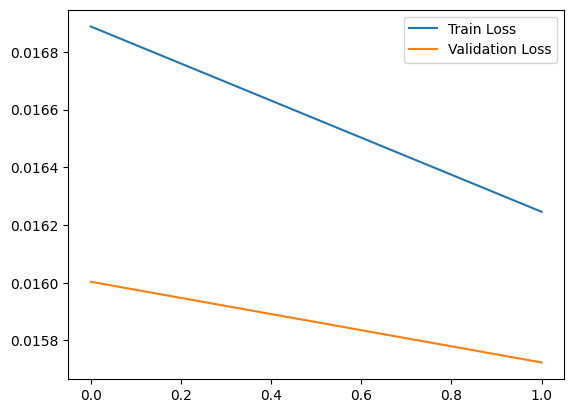

In [114]:
plt.plot(history["epoch"], [x.cpu().detach().numpy() for x in history["train_loss"]], label="Train Loss")
plt.plot(history["epoch"], [x.cpu().detach().numpy() for x in history["val_loss"]], label="Validation Loss")
plt.legend()
plt.show()

torch.Size([3, 512, 768])


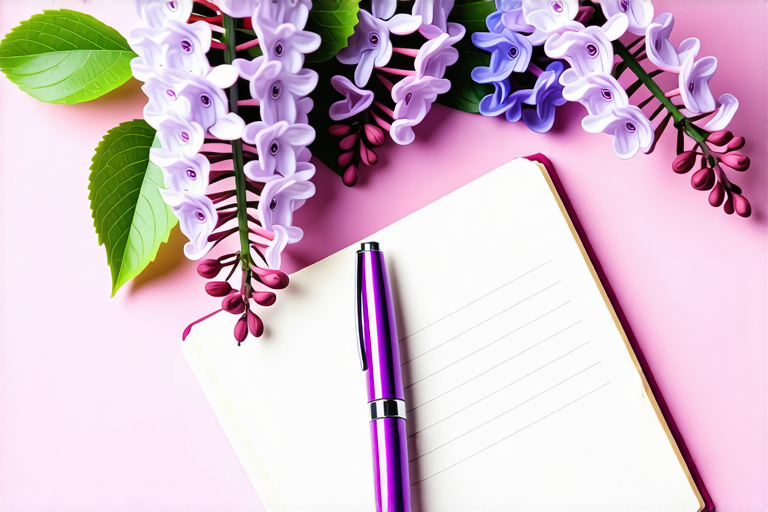

In [97]:
TEST_IMG_PATH = "../data/test_data_v2/0a4b8569dd9f4c1296c8e622b3bcbdf9.jpg"
img = torchvision.io.read_image(TEST_IMG_PATH)
print(img.shape)
transforms.ToPILImage()(img)

torch.Size([3, 64, 64])


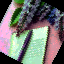

In [99]:
img = DEFAULT_TRANSFORMER(Image.open(TEST_IMG_PATH))
img = img.to(DEVICE)
print(img.shape)
transforms.ToPILImage()(img)

In [115]:
x, y = next(iter(val_dataloader))
x.shape, y

(torch.Size([32, 3, 64, 64]),
 tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
         0, 1, 1, 1, 0, 1, 0, 0]))

In [116]:
x = x.to(DEVICE)
val_preds = model(x)
val_preds = torch.argmax(torch.softmax(val_preds, dim=1), dim=1)
val_preds

tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0])

In [117]:
(val_preds - y).sum()/32

tensor(0.)